Set OBSGEO-B to    -6.423449 from OBSGEO-[XYZ].
Set OBSGEO-H to 1338407622.672 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-09T20:12:50.680' from MJD-AVG.
Set DATE-END to '2023-09-09T22:16:17.386' from MJD-END'. [astropy.wcs.wcs]


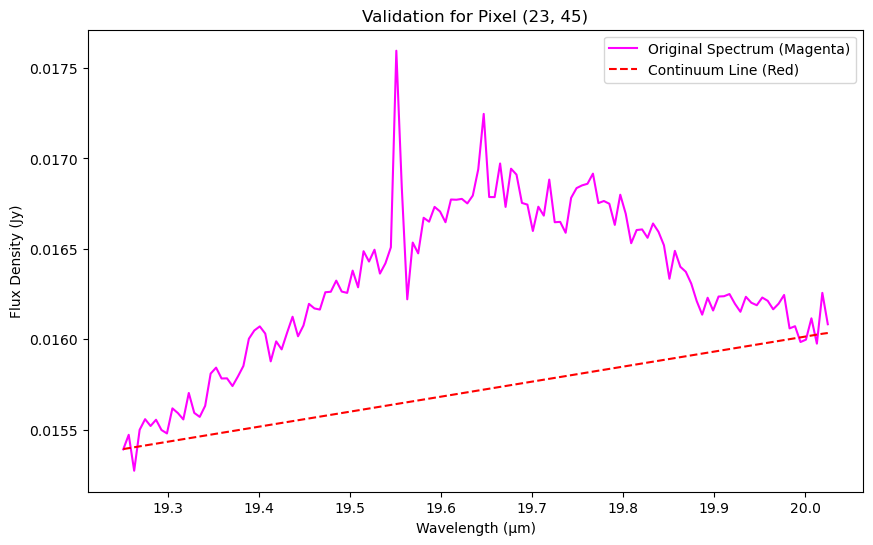

Fraction of negative values: 14.63%
Difference FITS file saved at 19.25orginalflux-continuum_22.4-24.05_corrected.fits


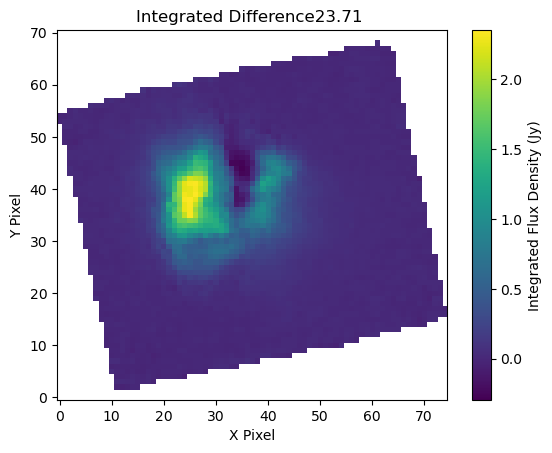

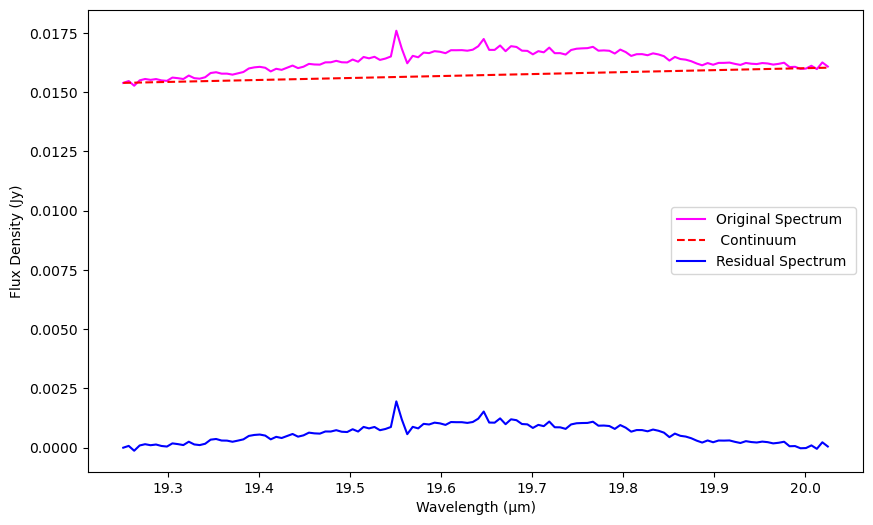

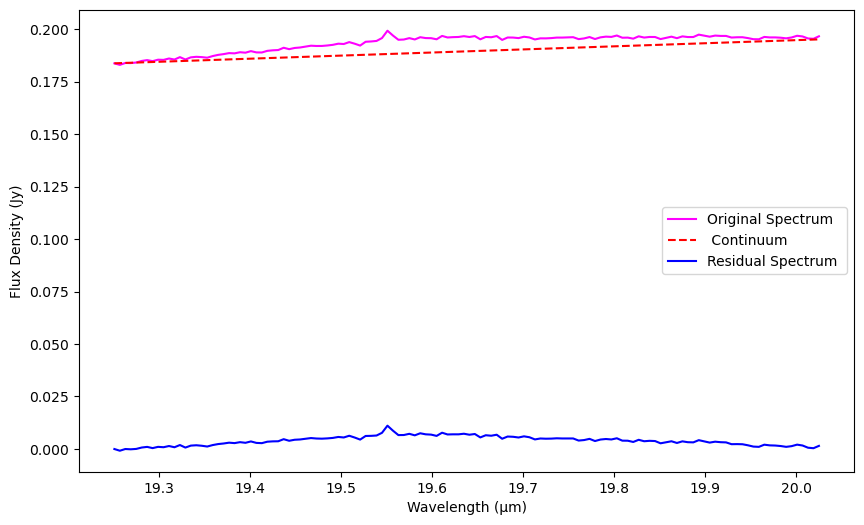

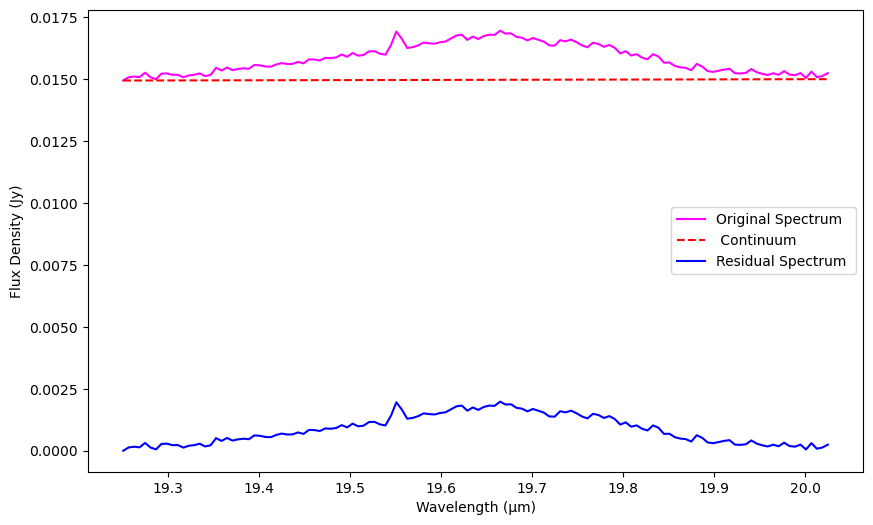

Negative values fraction: 14.63%
Positive values fraction: 53.49%


In [13]:
import numpy as np
from astropy.io import fits
from mpdaf.obj import Cube
from astropy import units as u
import matplotlib.pyplot as plt


cube_path = '/Users/mary/Fits image of JWST/ngc6302_ch4-long_s3d.fits'
continuum_path = '25continuum_line.fits'
output_path = '25orginalflux-continuum_24.60-25.24_corrected.fits'
cube = Cube(cube_path)

pixel_size_arcsec = cube.wcs.get_step(unit=u.arcsec)[0]  
solid_angle = (pixel_size_arcsec * u.arcsec).to(u.rad)**2  
flux_density = cube.data * solid_angle.value * 1e6 

with fits.open(continuum_path) as hdul:
    continuum_data = hdul[0].data
    continuum_header = hdul[0].header
    continuum_crval3 = continuum_header['CRVAL3']
    continuum_cdelt3 = continuum_header['CDELT3']
    continuum_naxis3 = continuum_data.shape[0]
    continuum_wavelengths = continuum_crval3 + np.arange(continuum_naxis3) * continuum_cdelt3

wavelengths = cube.wave.coord()

range_min, range_max = 24.60, 25.24
mask = (wavelengths >= range_min) & (wavelengths <= range_max)
filtered_flux_density = flux_density[mask, :, :] 
filtered_wavelengths = wavelengths[mask] 

aligned_continuum = np.zeros_like(filtered_flux_density)
for y in range(filtered_flux_density.shape[1]):
    for x in range(filtered_flux_density.shape[2]):
        aligned_continuum[:, y, x] = np.interp(filtered_wavelengths, continuum_wavelengths, continuum_data[:, y, x])

# Debug
y_pixel, x_pixel = 23, 45 
original_spectrum = filtered_flux_density[:, y_pixel, x_pixel]
continuum_spectrum = aligned_continuum[:, y_pixel, x_pixel]

plt.figure(figsize=(10, 6))
plt.plot(filtered_wavelengths, original_spectrum, label="Original Spectrum (Magenta)", color="magenta")
plt.plot(filtered_wavelengths, continuum_spectrum, label="Continuum Line (Red)", color="red", linestyle="--")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux Density (Jy)")
plt.legend()
plt.title(f"Validation for Pixel ({y_pixel}, {x_pixel})")
plt.savefig("25check")
plt.show()

difference_cube = filtered_flux_density - aligned_continuum
negative_fraction = np.sum(difference_cube < 0) / difference_cube.size
print(f"Fraction of negative values: {negative_fraction:.2%}")

if np.ma.isMaskedArray(difference_cube):
    difference_cube = difference_cube.filled(np.nan) 

cube_header = fits.getheader(cube_path, ext=1)
cube_header['CRVAL3'] = range_min 
cube_header['CDELT3'] = continuum_cdelt3  
cube_header['NAXIS3'] = len(filtered_wavelengths) 

fits.writeto(output_path, difference_cube.astype('float32'), header=cube_header, overwrite=True)
print(f"Difference FITS file saved at {output_path}")

plt.imshow(np.sum(difference_cube, axis=0), origin='lower', cmap='viridis')
plt.colorbar(label='Integrated Flux Density (Jy)')
plt.title('Integrated Difference23.71 ')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.savefig("e")
plt.show()

difference_cube = filtered_flux_density - aligned_continuum

#for check
debug_pixels = [(23, 45), (30, 35), (40, 50)]
for y_pixel, x_pixel in debug_pixels:
    original_spectrum = filtered_flux_density[:, y_pixel, x_pixel]
    continuum_spectrum = aligned_continuum[:, y_pixel, x_pixel]
    residual_spectrum = difference_cube[:, y_pixel, x_pixel]
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_wavelengths, original_spectrum, label="Original Spectrum ", color="magenta")
    plt.plot(filtered_wavelengths, continuum_spectrum, label=" Continuum ", color="red", linestyle="--")
    plt.plot(filtered_wavelengths, residual_spectrum, label="Residual Spectrum ", color="blue")
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Flux Density (Jy)")
    plt.legend()
    plt.savefig("Spectra for Pixel")
    plt.show()


negative_fraction = np.sum(difference_cube < 0) / difference_cube.size
positive_fraction = np.sum(difference_cube > 0) / difference_cube.size
print(f"Negative values fraction: {negative_fraction:.2%}")
print(f"Positive values fraction: {positive_fraction:.2%}")


